In [1]:
import numpy as np
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
import time
import pandas as pd

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import matplotlib.font_manager # to solve: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.

font_size = 10

# matplotlib.rcParams.keys()
rc={'font.size': font_size, 'axes.labelsize': font_size, 'figure.dpi':400,'axes.linewidth':1,
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size} # 'figure.figsize':(11.7/1.5,8.27/1.5)

sns.set(style='ticks',rc=rc) 
sns.set_context("paper")
# sns.palplot(sns.color_palette(flatui))

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.unicode_minus']=False # negative minus sign
centimeter = 1/2.54  # centimeter in inches

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
# sc.settings.set_figure_params(dpi=400, dpi_save=400, figsize=(6,6), fontsize = 10, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.1 scipy==1.6.2 pandas==1.2.4 scikit-learn==1.1.2 statsmodels==0.12.2 python-igraph==0.9.11 pynndescent==0.5.7


In [4]:
from _utils import get_adata, update_celltype,set_cell2loc_palette
import edge


In [5]:
sample_list=['CDQ_C3','CDQ_D4','CDQ_E3','CXF_D1','HX_D3','LJT_F6','TJ_E4','GXY_F3','ZZW_F5']
adata_paths = [r'/hwfssz1/ST_HEALTH/P20Z10200N0170/jiangyongchao/project/HX_lung/cell2loc/'+pat_id+'_bin100.leiden.cell2location.h5ad' 
               for pat_id in sample_list]
adata_fnames = dict(zip(sample_list, adata_paths))


In [6]:
pat_id = 'TJ_E4' # IA
adata=get_adata(adata_fnames[pat_id], log=True)

normalizing counts per cell
    finished (0:00:02)


In [7]:
celltype_list = ['AT1', 'AT2', 'AT2_like', 'B_cell', 'Basal', 'Ciliated', 'Club', 'DC', 
                 'Endothelial', 'Erythrocyte', 'Fibroblast', 'Granulocyte', 'MAST_cell', 'Macrophage', 'NK', 'T_cell']
update_celltype(adata,celltype_list,min_frac_ct=1.2,update_cell2loc=True)


In [8]:
adata

AnnData object with n_obs × n_vars = 17823 × 13296
    obs: 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'sample', '_indices', '_scvi_batch', '_scvi_labels', 'AT1', 'AT2', 'AT2_like', 'B_cell', 'Basal', 'Ciliated', 'Club', 'DC', 'Endothelial', 'Erythrocyte', 'Fibroblast', 'Granulocyte', 'MAST_cell', 'Macrophage', 'NK', 'T_cell', 'cell2location_max'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'SYMBOL', 'MT_gene'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'mod', 'log1p'
    obsm: 'MT', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'spatial', 'stds_cell_abundance_w_sf', 'cell_type_update'
    

In [147]:
# adata.uns['mod']

In [101]:
im_map = edge.creat_imarray(adata)
area, boundary = edge.find_boundary(im_map, min_thre_binary=85, 
                 max_thre_binary=255, 
                 gaussian_sigma=10, 
                 canny_thre1=200, 
                 canny_thre2=255)


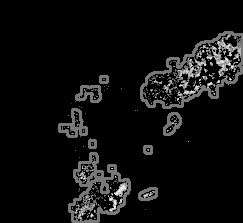

In [102]:
from PIL import Image
import cv2

im_map_raw = im_map.copy()
cv2.drawContours(im_map_raw, boundary, -1, 120, 2)
Image.fromarray(im_map_raw)

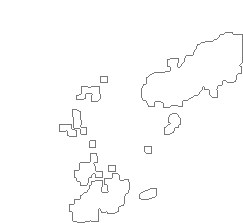

In [103]:
# just show boundary
CntExternalMask = np.ones(im_map.shape[:2], dtype="uint8") * 255
cv2.drawContours(CntExternalMask, boundary, -1, 120, 1)
Image.fromarray(CntExternalMask)

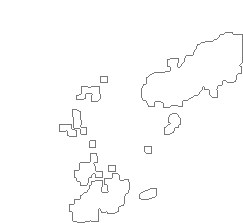

In [104]:
smoothed_b = edge.smooth_boundary(boundary, factor=0.001) # 0.002

CntExternalMask = np.ones(im_map.shape[:2], dtype="uint8") * 255
cv2.drawContours(CntExternalMask, smoothed_b, -1, 120, 1)
Image.fromarray(CntExternalMask)


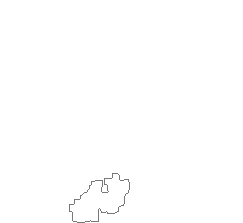

In [105]:
CntExternalMask = np.ones(im_map.shape[:2], dtype="uint8") * 255
cv2.drawContours(CntExternalMask, [smoothed_b[1]], -1, 120, 1)
Image.fromarray(CntExternalMask)

In [106]:
def _filter_line(bound_ploy, x_left, x_right, y_bottom, y_top):
    """
    x_left < x_right
    y_bottom > y_top
    """
    u_bound = []
    for x,y in zip(bound_ploy.boundary.xy[0],bound_ploy.boundary.xy[1]):
        if (x > x_left and y > y_top) and (x < x_right and y < y_bottom):
            u_bound.append([x,y])
    return np.array(u_bound)

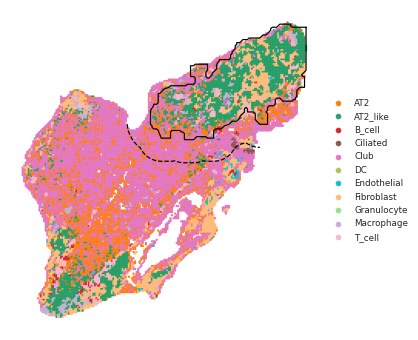

In [154]:
# draw plot to show boundary
# distance = 10, equal to 500 mum

fig,ax = plt.subplots(figsize=(6,6))
sc.pl.spatial(adata, color=['cell2location_max'], title='', spot_size=1.5,frameon = False, show=False, ax=ax,palette = set_cell2loc_palette(celltype_list))

roi_b = smoothed_b[0]
o_b, f_b, b_b = edge.find_distance_boundary(roi_b, distance=15)

x_left, x_right = ax.get_xlim()
y_bottom, y_top = ax.get_ylim()

ob_b = _filter_line(o_b, x_left+10, x_right-10, y_bottom, y_top)
fb_b = _filter_line(f_b, x_left+50, x_right-40, y_bottom-100, y_top+70)
bb_b = _filter_line(b_b, x_left, x_right, y_bottom, y_top)

ax.plot(ob_b[:,0],ob_b[:,1], color='black')
x = np.sort(fb_b[:,0])
y = fb_b[:,1][np.argsort(fb_b[:,0])]
ax.plot(x,y, color='black', linestyle='--')
# ax.plot(bb_b[:,0],bb_b[:,1], color='black', linestyle='dashed')

# roi_b = smoothed_b[1]
# o_b, f_b, b_b = edge.find_distance_boundary(roi_b, distance=10)

# x_left, x_right = ax.get_xlim()
# y_bottom, y_top = ax.get_ylim()

# ob_b = _filter_line(o_b, x_left+10, x_right-10, y_bottom, y_top)
# # fb_b = _filter_line(f_b, x_left+50, x_right-40, y_bottom-100, y_top+70)
# bb_b = _filter_line(b_b, x_left+20, x_right-10, y_bottom-55, y_top+10)

# ax.plot(ob_b[:,0],ob_b[:,1], color='black')
# # ax.plot(fb_b[:,0],fb_b[:,1], color='black', linestyle='dashed')
# ax.plot(bb_b[:,0],bb_b[:,1], color='black', linestyle='dashed')

# plt.savefig(f"results/edge/boundary_{pat_id}.pdf", dpi=400, bbox_inches='tight',format='pdf')

In [22]:
ax.get_xlim(),ax.get_ylim()

((-9.825000000000001, 211.825), (231.775, 11.225))

In [23]:
from shapely.geometry import Point
coords = adata.obsm['spatial']
coords_pt = list(map(Point, zip(coords[:,0],coords[:,1])))

def get_pt_btw_boundary(coords_pt, outer_b, in_b):
    return np.array([1 if outer_b.contains(i) and not in_b.contains(i) else 0 for i in coords_pt])

In [24]:
distances = [5, 10, 15, 20]

o_b, f_b_p5, b_b_m5 = edge.find_distance_boundary(roi_b, distance=5)
_, f_b_p10, b_b_m10 = edge.find_distance_boundary(roi_b, distance=10)
_, f_b_p15, b_b_m15 = edge.find_distance_boundary(roi_b, distance=15)
_, f_b_p20, b_b_m20 = edge.find_distance_boundary(roi_b, distance=20)

pt_in_p5_ob = get_pt_btw_boundary(coords_pt, f_b_p5, o_b)
pt_in_p10_p5 = get_pt_btw_boundary(coords_pt, f_b_p10, f_b_p5)
pt_in_p15_p10 = get_pt_btw_boundary(coords_pt, f_b_p15, f_b_p10)
pt_in_p20_p15 = get_pt_btw_boundary(coords_pt, f_b_p20, f_b_p15)

pt_in_m5_ob = get_pt_btw_boundary(coords_pt, o_b, b_b_m5)
pt_in_m10_m5 = get_pt_btw_boundary(coords_pt, b_b_m5, b_b_m10)
pt_in_m15_m10 = get_pt_btw_boundary(coords_pt, b_b_m10, b_b_m15)
pt_in_m20_m15 = get_pt_btw_boundary(coords_pt, b_b_m15, b_b_m20)


In [25]:
adata_p5_ob = adata[pt_in_p5_ob==1,:]
adata_p10_p5 = adata[pt_in_p10_p5==1,:]
adata_p15_p10 = adata[pt_in_p15_p10==1,:]
adata_p20_p15 = adata[pt_in_p20_p15==1,:]

adata_m5_ob = adata[pt_in_m5_ob==1,:]
adata_m10_m5 = adata[pt_in_m10_m5==1,:]
adata_m15_m10 = adata[pt_in_m15_m10==1,:]
adata_m20_m15 = adata[pt_in_m20_m15==1,:]

In [26]:
adas = [adata_p5_ob, adata_p10_p5, adata_p15_p10, adata_p20_p15, adata_m5_ob, adata_m10_m5, adata_m15_m10, adata_m20_m15]
dist_lab = ['0-5','5-10','10-15','15-20', '-5-0', '-10--5','-15--10','-20--15']
# orders = ['15-20','10-15','5-10','0-5', '-5-0', '-10--5','-15--10','-20--15']

df_cell_type_frac_regs=None
for i, ada in enumerate(adas):
    if i==0:
        df_cell_type_frac = ada.obsm['cell_type_update'].copy()
        df_cell_type_frac['region'] = [dist_lab[i]] * df_cell_type_frac.shape[0]
        df_cell_type_frac_regs = df_cell_type_frac
    else:
        df_cell_type_frac1 = ada.obsm['cell_type_update'].copy()
        df_cell_type_frac1['region'] = [dist_lab[i]] * df_cell_type_frac1.shape[0]
        df_cell_type_frac_regs = pd.concat([df_cell_type_frac_regs, df_cell_type_frac1], ignore_index=True)


In [27]:
import pickle
with open(f'results/edge/adatas_{pat_id}.pkl','wb') as f:
    pickle.dump(adas, f)

In [28]:
df_cell_type_frac_regs

,AT1,AT2,AT2_like,B_cell,Basal,Ciliated,Club,DC,Endothelial,Erythrocyte,...,Granulocyte,MAST_cell,Macrophage,NK,T_cell,sec_max_ind,top_max_ind,ratio,ct_update,region
0,0.102277,0.083925,0.020447,0.159577,0.055716,0.040020,0.076501,0.021893,0.160050,0.011673,...,0.040457,0.034910,0.006771,0.036759,0.096364,3,8,1.002964,NOT_SPEC,0-5
1,0.042389,0.179867,0.084491,0.154245,0.045382,0.065215,0.045120,0.057880,0.044334,0.005594,...,0.020213,0.017113,0.039416,0.024817,0.085382,3,1,1.166115,NOT_SPEC,0-5
2,0.044499,0.130642,0.147016,0.088361,0.059147,0.053990,0.036563,0.069665,0.040301,0.008377,...,0.039406,0.024536,0.080735,0.028223,0.079308,1,2,1.125336,NOT_SPEC,0-5
3,0.048606,0.181116,0.038544,0.083515,0.128205,0.086709,0.051999,0.020583,0.074476,0.006078,...,0.037639,0.011499,0.056036,0.025323,0.034951,4,1,1.412699,AT2,0-5
4,0.028016,0.049807,0.150957,0.123867,0.054181,0.076435,0.029164,0.043088,0.073582,0.004867,...,0.014605,0.076512,0.042125,0.027398,0.156552,2,15,1.037068,NOT_SPEC,0-5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12428,0.045174,0.066204,0.204251,0.068668,0.045352,0.033403,0.042402,0.078739,0.038368,0.025960,...,0.016980,0.043544,0.023834,0.038651,0.140503,15,2,1.453714,AT2_like,-20--15
12429,0.050073,0.112582,0.166375,0.056528,0.052293,0.040670,0.055112,0.082254,0.055061,0.012197,...,0.030006,0.030358,0.013400,0.041763,0.110020,1,2,1.477815,AT2_like,-20--15
12430,0.040474,0.084926,0.233904,0.076457,0.045223,0.037489,0.038322,0.083093,0.039079,0.011420,...,0.019899,0.029820,0.030157,0.028660,0.118122,15,2,1.980189,AT2_like,-20--15
12431,0.027973,0.055512,0.215998,0.072753,0.097440,0.052259,0.026008,0.088020,0.048184,0.004738,...,0.009838,0.040733,0.061906,0.023916,0.100022,15,2,2.159516,AT2_like,-20--15


In [29]:
df_cell_type_frac_regs.to_csv(f"results/edge/cell_boundary_{pat_id}.csv", index=False)

In [30]:
from matplotlib import cm, colors
x = list(map(colors.to_hex, sns.color_palette('pastel')))
print(x)
x = list(map(colors.to_hex, sns.color_palette('bright')))
print(x)


['#a1c9f4', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#cfcfcf', '#fffea3', '#b9f2f0']
['#023eff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#a3a3a3', '#ffc400', '#00d7ff']


In [31]:
bg_f = ['#b9f2f0', '#ffb482', '#8de5a1', '#ff9f9b', '#d0bbff', '#debb9b', '#fab0e4', '#fffea3', ]
ln_f = ['#00d7ff', '#ff7c00', '#1ac938', '#e8000b', '#8b2be2', '#9f4800', '#f14cc1', '#ffc400', ]

In [32]:
sns.color_palette(x)

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [33]:
import plotting

In [34]:
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches

def plot_show(df_cell_type_frac_regs, val_col, save=True, y_label='Fraction of Cell Type', gene=False, gene_cell_type=None):
    
    comp_pairs = [('15-20','10-15'),('10-15','5-10'),('5-10','0-5'), ('0-5','-5-0'), 
                  ('-5-0','-10--5'), ('-10--5','-15--10'),('-15--10','-20--15')]
    orders = ['15-20','10-15','5-10','0-5', '-5-0', '-10--5','-15--10','-20--15']

    fig = plt.figure(figsize=(4,3))
    gs1 = GridSpec(2, 1, hspace=0.3,height_ratios=[8, 1.2])
    ax1 = fig.add_subplot(gs1[0])
    ax2 = fig.add_subplot(gs1[1])

    axa = plotting.boxplot(df_cell_type_frac_regs, 'region', val_col, ax1, comp_pairs,orders=orders, gene=gene)

    ax1.axvline(3.5,linewidth=0.8, color='gray', linestyle='dashed',ymax=0.6)
    ax1.tick_params(pad=1)
    ax1.set_xticklabels(labels=[r'-1000 $\mu$m','-750 $\mu$m','-500 $\mu$m','-250 $\mu$m','250 $\mu$m','500 $\mu$m','750 $\mu$m','1000 $\mu$m'], rotation=20,ha='center', va='top')
    ax1.set_xlabel(None)
    ax1.set_ylabel(y_label)
    if not gene:
        ax1.set_title(val_col)
    else:
        ax1.set_title(f'$\it{val_col}$')

    p = patches.FancyArrowPatch((0, 0.5), (1, 0.5), arrowstyle='<|-|>', mutation_scale=10,color='k')
    ax2.add_patch(p)
    ax2.plot([0.5,0.5],[0.5016,0.51],color='k')
    ax2.text(0.15, 0.472, 'Normal', ha='center', va='center')
    ax2.text(0.5, 0.472, 'Boundary', ha='center', va='center')
    ax2.text(0.85, 0.472, 'Tumor',  ha='center', va='center')
    ax2.axis('off')
    sns.despine()
    if save:
        if gene:
            plt.savefig(f"results/edge/{gene_cell_type}_{val_col}_{pat_id}.pdf", dpi=400, bbox_inches='tight',format='pdf')
        else:
            plt.savefig(f"results/edge/ct_{val_col}_{pat_id}.pdf", dpi=400, bbox_inches='tight',format='pdf')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

15-20 vs. 10-15: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.606e-08 U_stat=1.079e+06
10-15 vs. 5-10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.924e-06 U_stat=1.241e+06
5-10 vs. 0-5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:7.053e-56 U_stat=1.598e+06
0-5 vs. -5-0: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.495e-253 U_stat=1.275e+06
-5-0 vs. -10--5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.113e-18 U_stat=1.352e+06
-10--5 vs. -15--10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.550e-02 U_stat=5.066e+05
-15--10 vs. -20--15: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg co

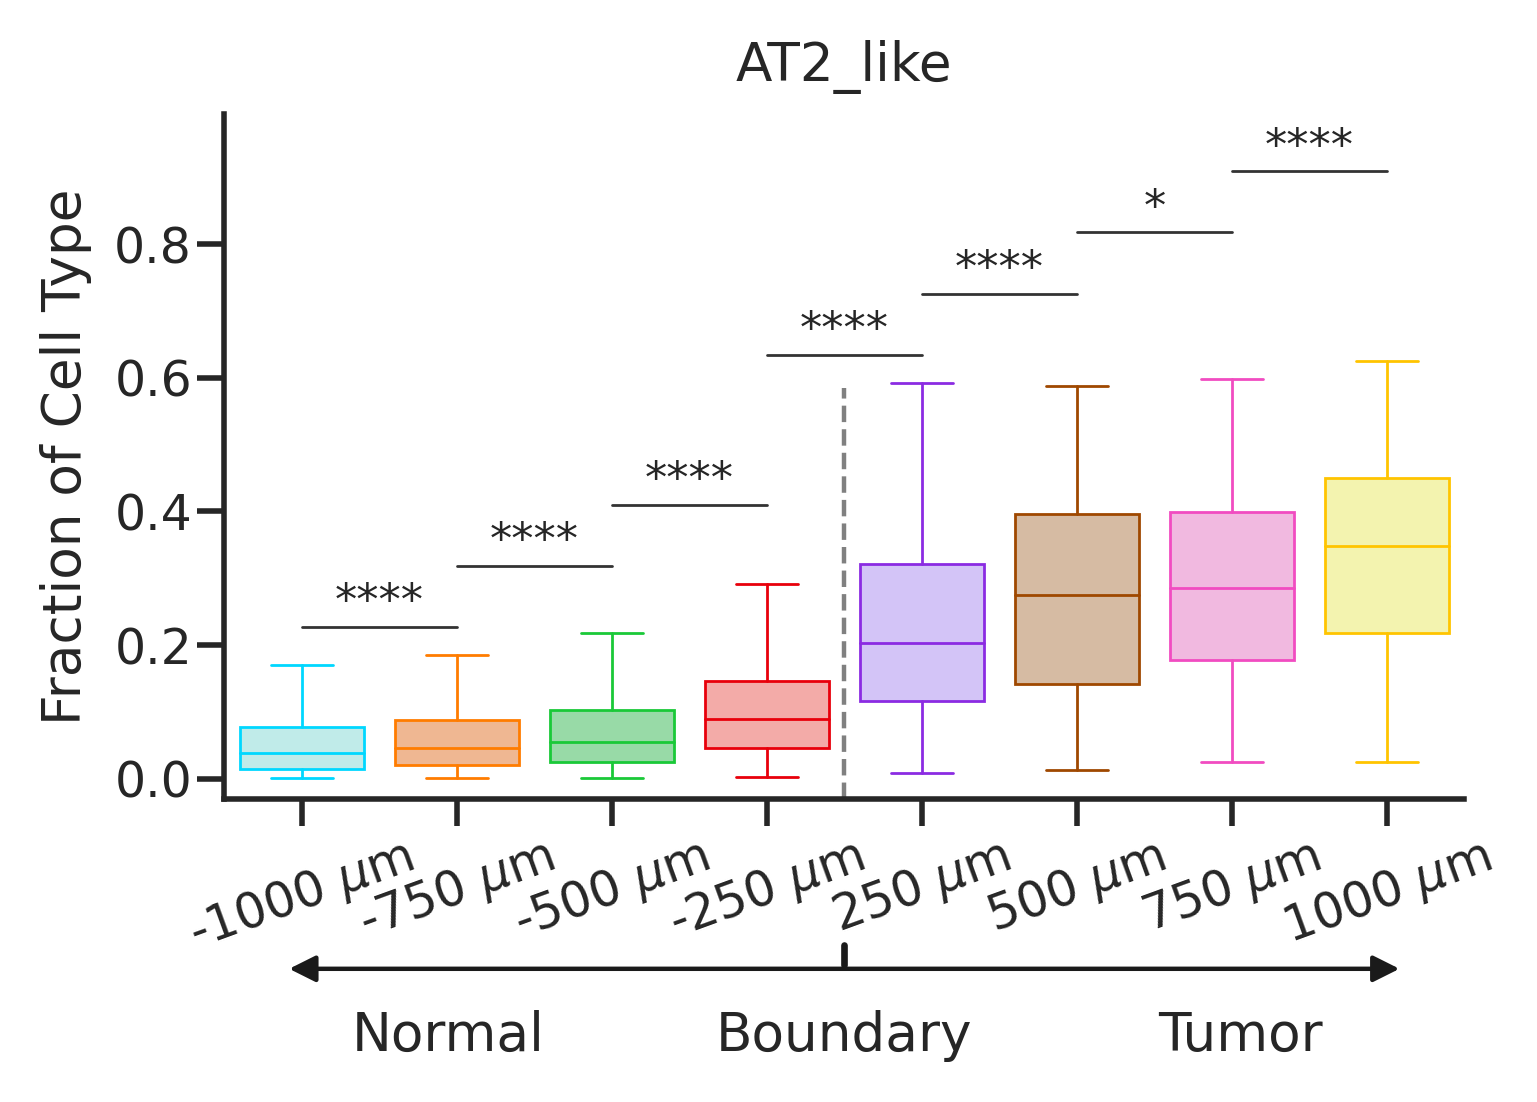

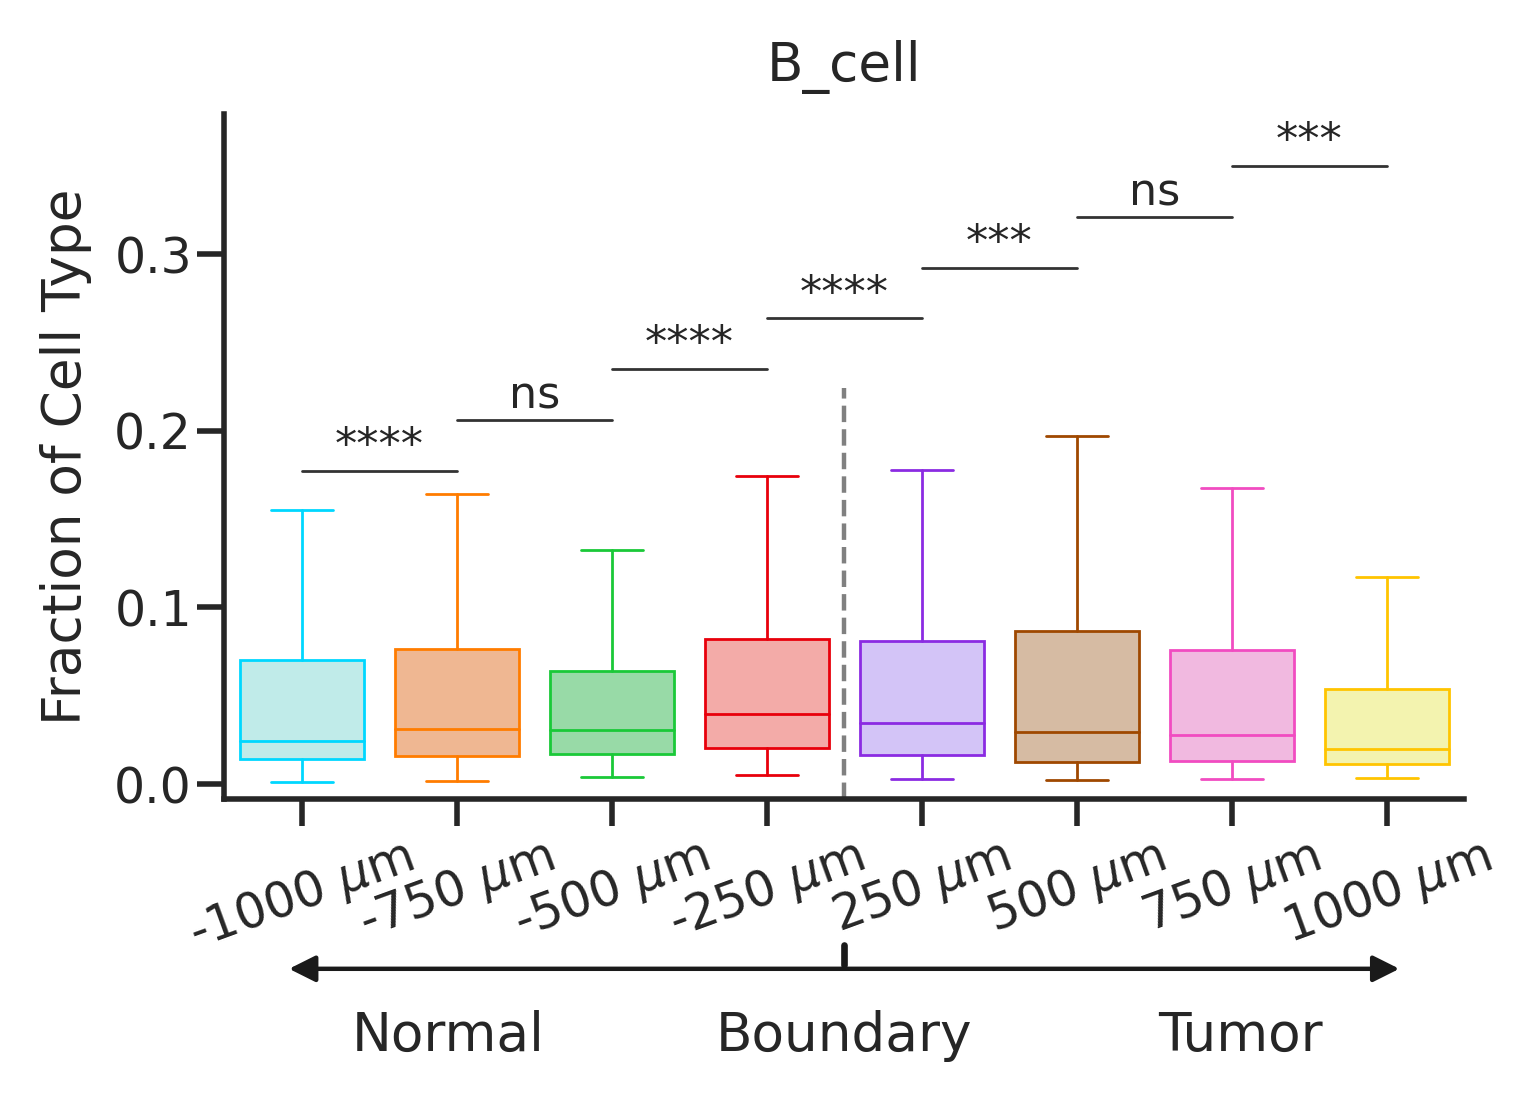

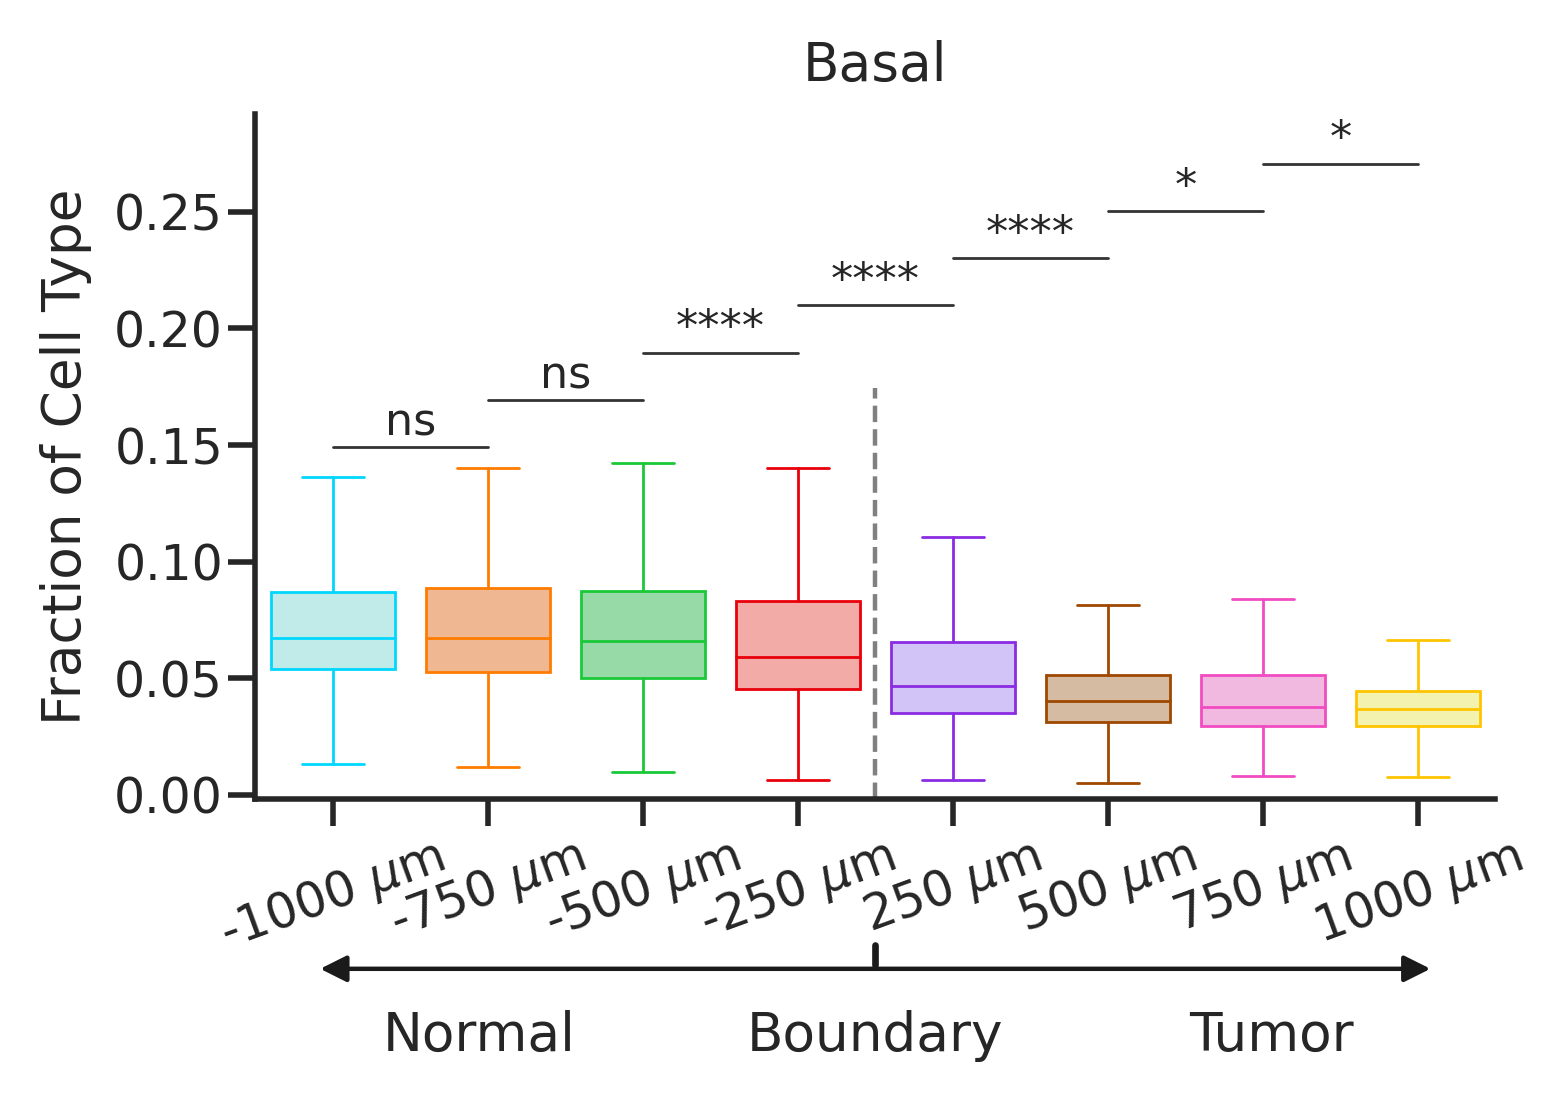

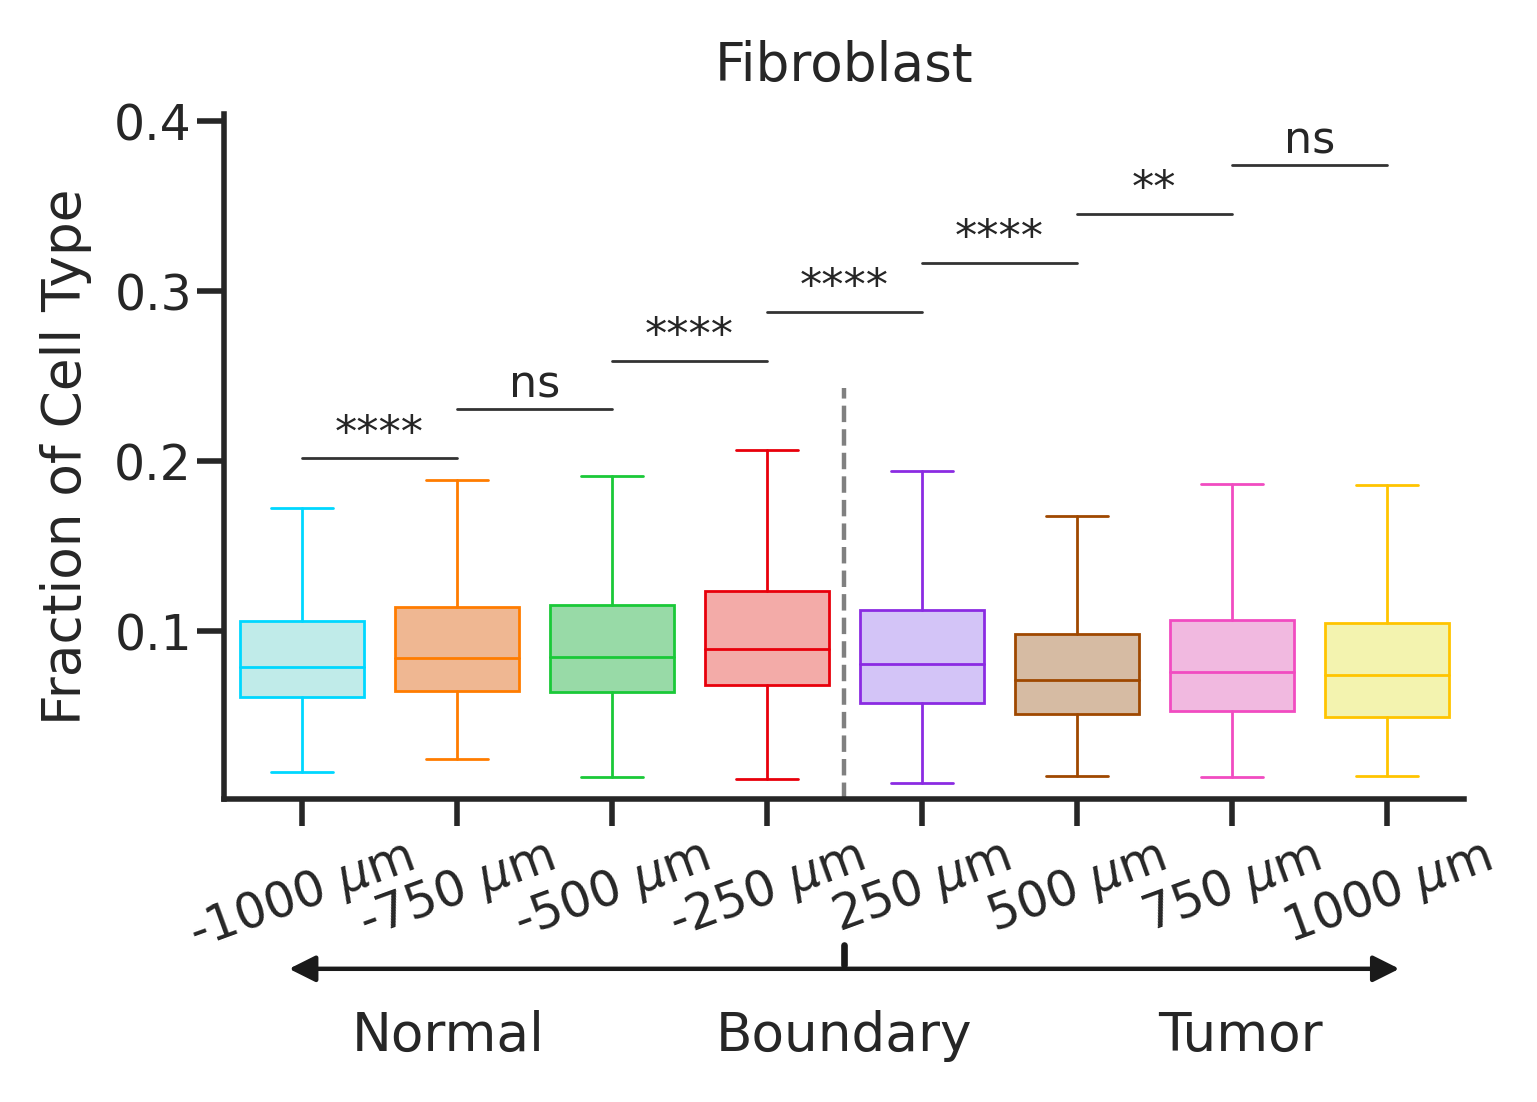

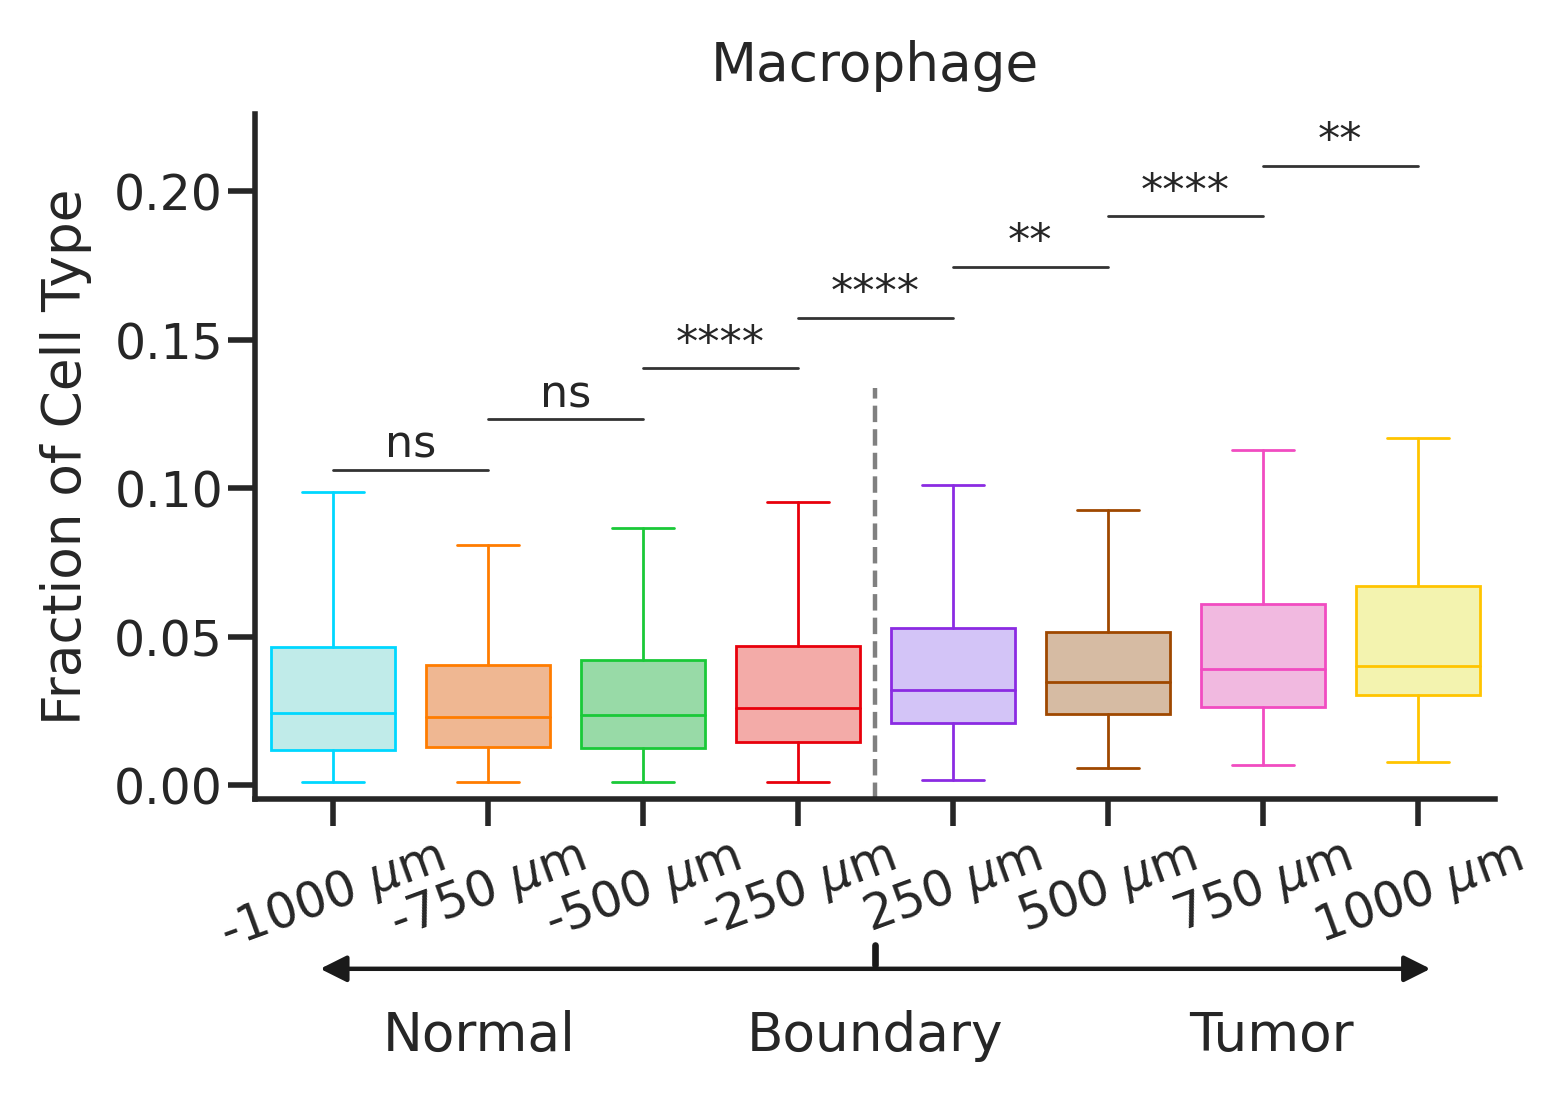

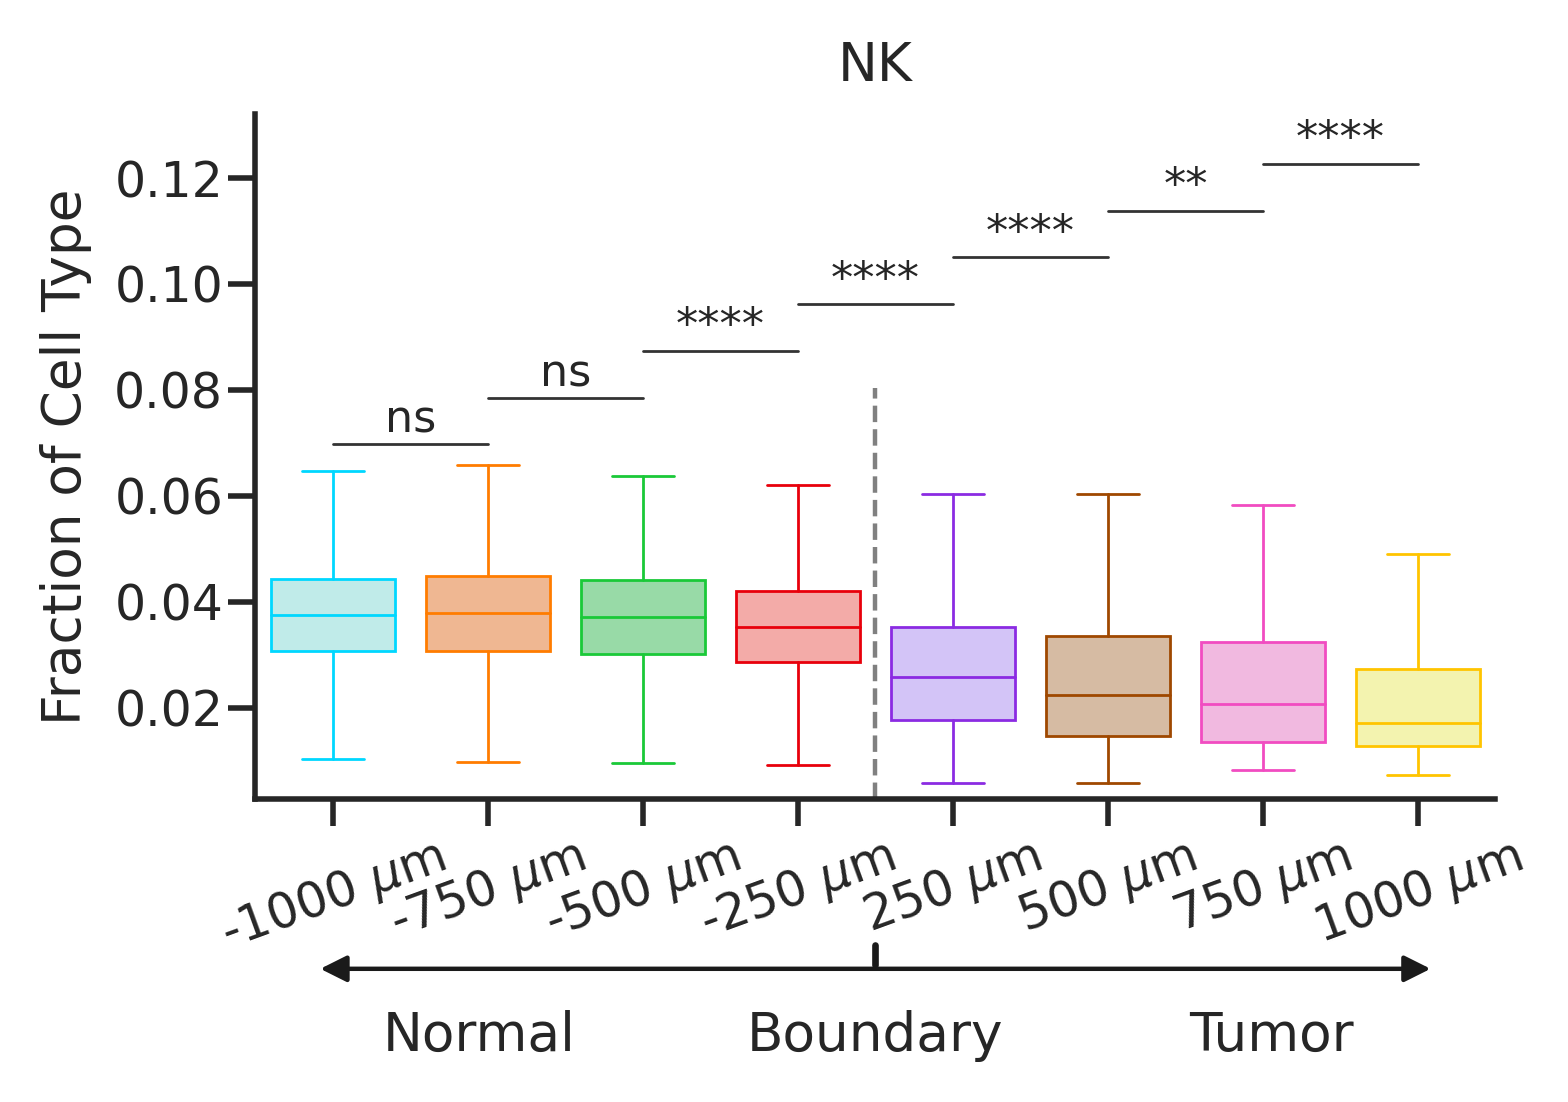

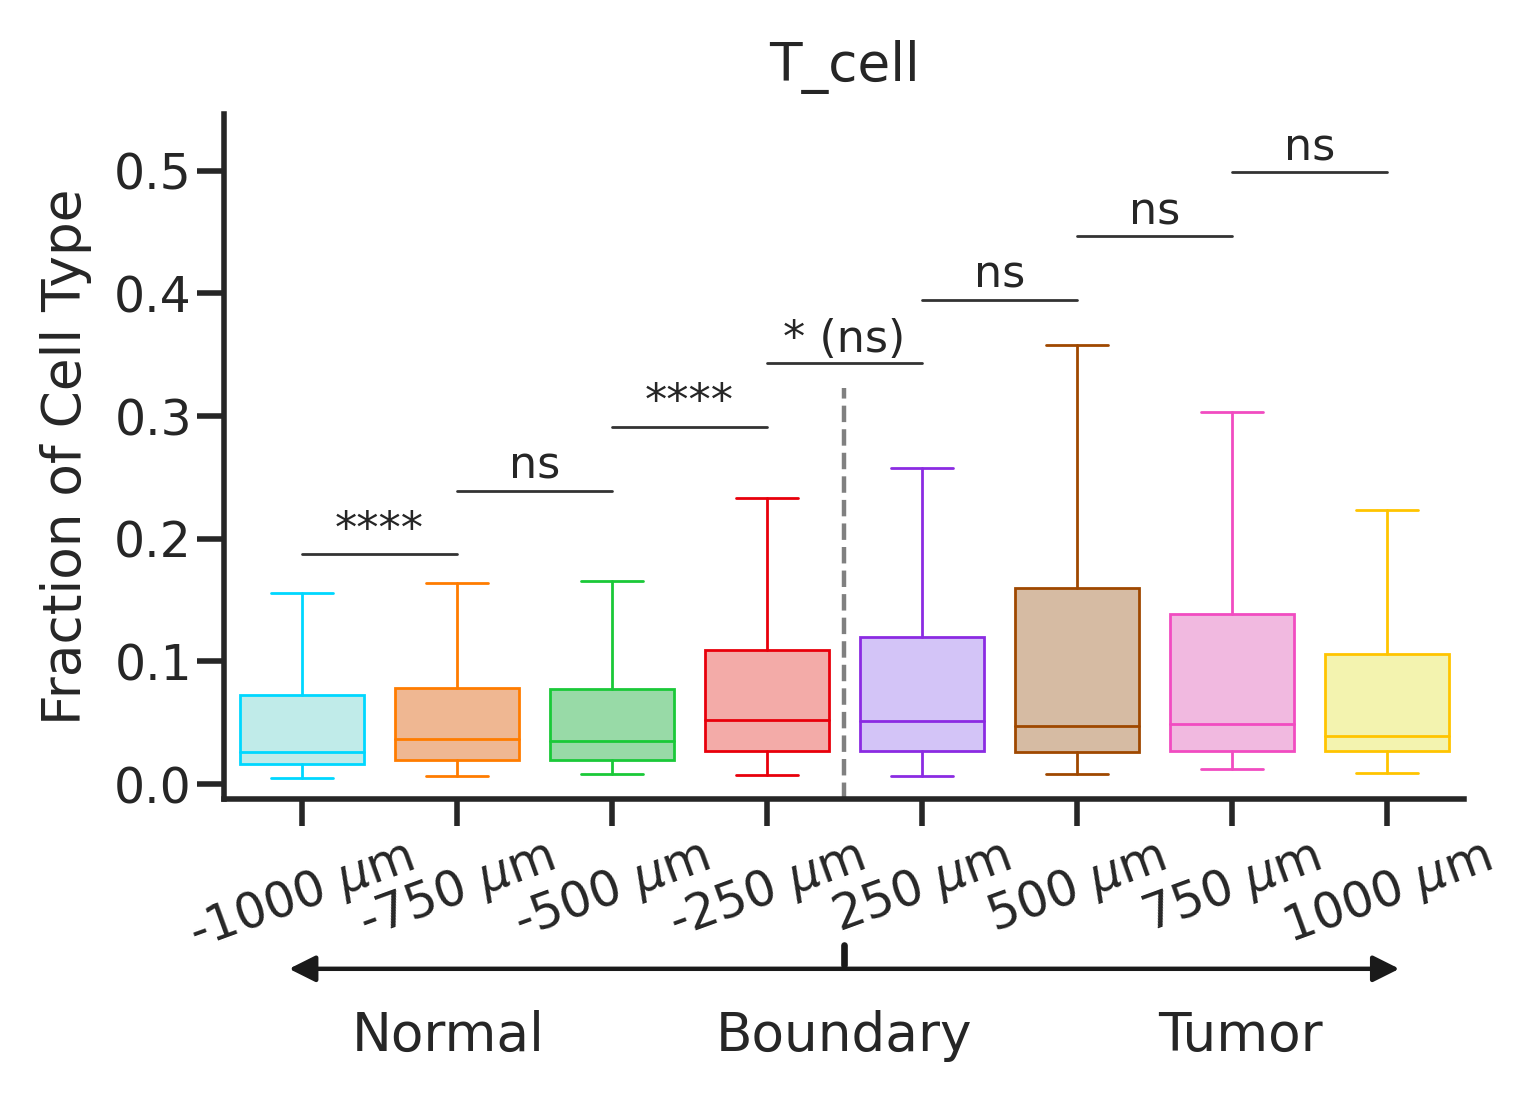

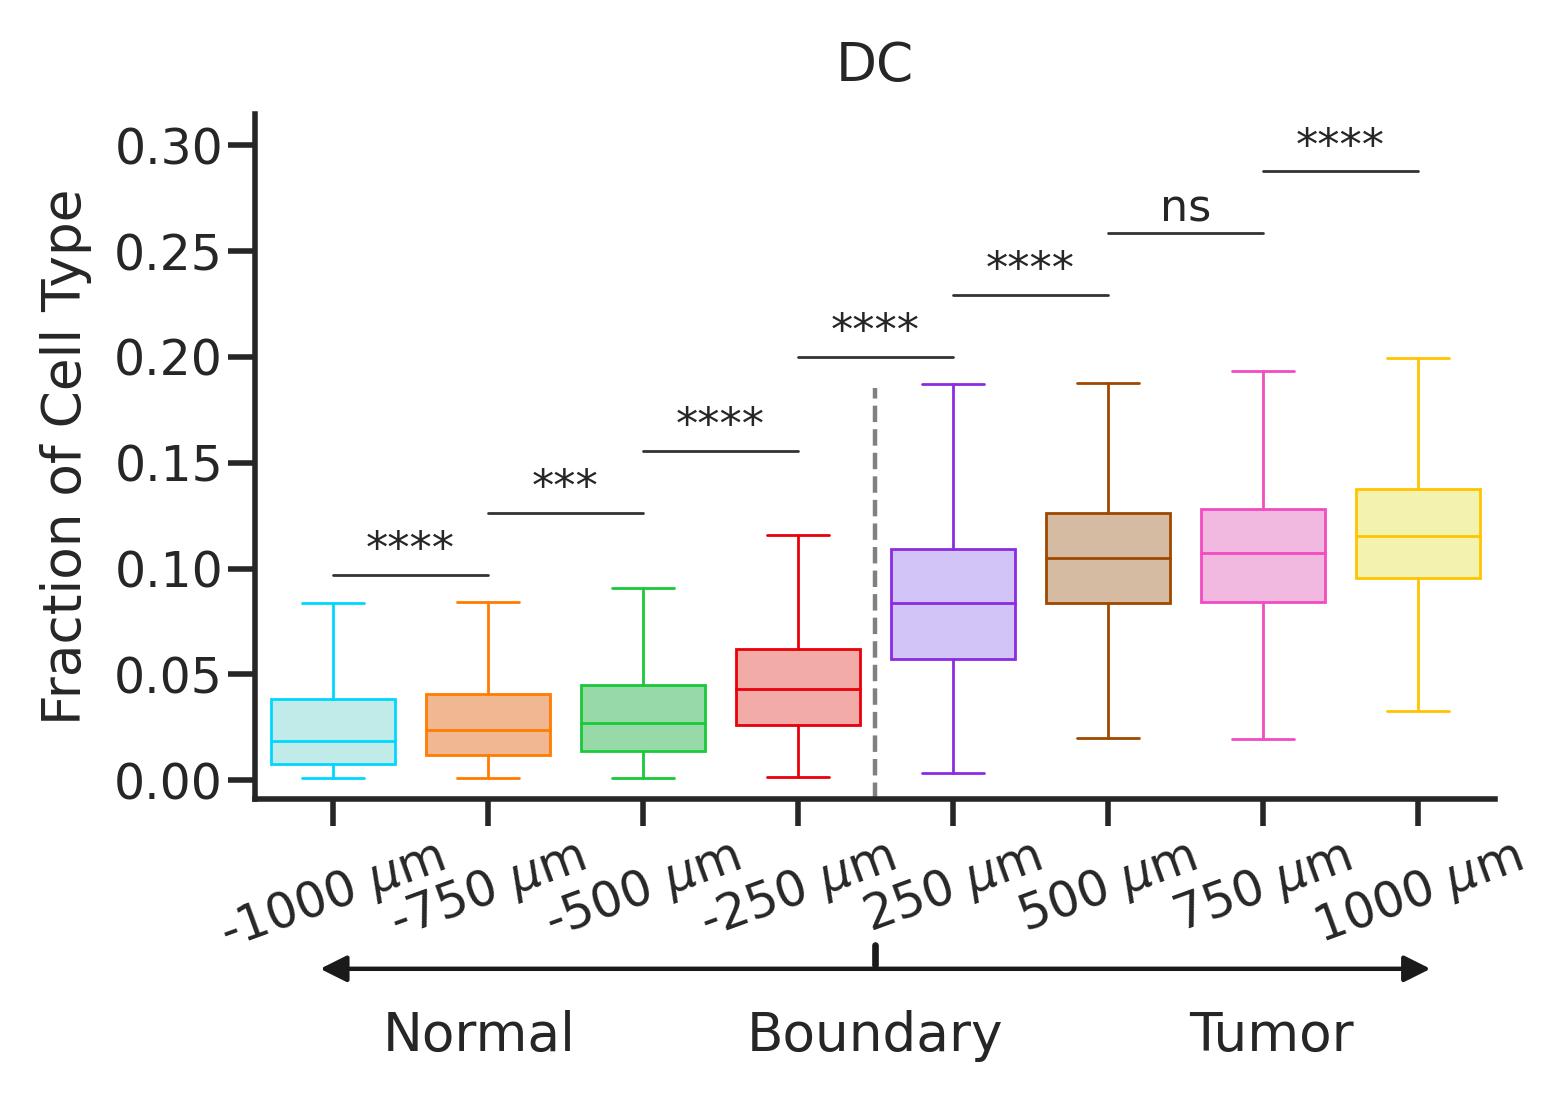

In [36]:
import matplotlib.font_manager # to solve: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
cells = ['AT2_like', 'B_cell', 'Basal', 'Fibroblast', 'Macrophage', 'NK', 'T_cell','DC']
for cc in cells:
    plot_show(df_cell_type_frac_regs,cc)

# Genes

In [37]:
celltype_list = ['AT1', 'AT2', 'AT2_like', 'B_cell', 'Basal', 'Ciliated', 'Club', 'DC', 
                 'Endothelial', 'Erythrocyte', 'Fibroblast', 'Granulocyte', 'MAST_cell', 'Macrophage', 'NK', 'T_cell']

gene_dict = {'DC': ['LYZ','HLA-DRB1','IL1B','LST1','HLA-DQA1','HLA-DQB1'],
            'Fibroblast':['LUM','DCN','FBLN1','APOD','COL1A1','IGFBP6','CFD'],
            'Macrophage':['CD68','MARCO','CTSD','C1QA','C1QB','APOC1','APOE'],
            'NK':['NKG7','GZMA','GNLY','CD3G','FGFBP2'],
            'T_cell':['CD2','CD3D','CD3E','CXCR4','IL32'],
             'B_cell':['MS4A1','FKBP11', 'DERL3','CD79A','MZB1','IGHA2'], # no 'IGLL5','IGJ' in data
            'Club':['SCGB1A1','SCGB3A1','PIGR','WFDC2'],
            'Ciliated':['CAPS','TPPP3','C9orf24'],
            'Endothelial':['RAMP2','VWF','GNG11','CLDNS','DARC'],
             'AT1':['RTKN2','EMP2'],
             'AT2':['PIGR', 'WFDC2','SFTA2','NAPSA','SFTPB','SFTPD','SFTPA1','SFTPC'],
             'AT2_like': ['MDK','TIMP1','IFI27','EPCAM','SCGB3A2'],
             'Basal':['KRT15','S100A2'] # no MIR205HG 
            }

In [52]:
adass = [adata_p5_ob.copy(), adata_p10_p5.copy(), adata_p15_p10.copy(), 
         adata_p20_p15.copy(), adata_m5_ob.copy(), adata_m10_m5.copy(), adata_m15_m10.copy(), adata_m20_m15.copy()]
dist_lab = ['0-5','5-10','10-15','15-20', '-5-0', '-10--5','-15--10','-20--15']

celltype_list = ['AT2_like', 'B_cell', 'Basal', 'Fibroblast', 'Macrophage', 'NK', 'T_cell']

celltype = 'T_cell'
df_gene=None
for i, ada in enumerate(adass):
    i_df_gene = ada[:, gene_dict[celltype]].to_df()
    i_df_gene['region'] = [dist_lab[i]] * i_df_gene.shape[0]
        
    if i==0:
        df_gene = i_df_gene
    else:
        df_gene = pd.concat([df_gene, i_df_gene], ignore_index=True)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

15-20 vs. 10-15: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.400e-04 U_stat=1.172e+06
10-15 vs. 5-10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:2.521e-01 U_stat=1.353e+06
5-10 vs. 0-5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.720e-02 U_stat=2.169e+06
0-5 vs. -5-0: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:3.668e-03 U_stat=2.836e+06
-5-0 vs. -10--5: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:1.511e-04 U_stat=1.547e+06
-10--5 vs. -15--10: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:6.197e-02 U_stat=5.206e+05
-15--10 vs. -20--15: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg cor

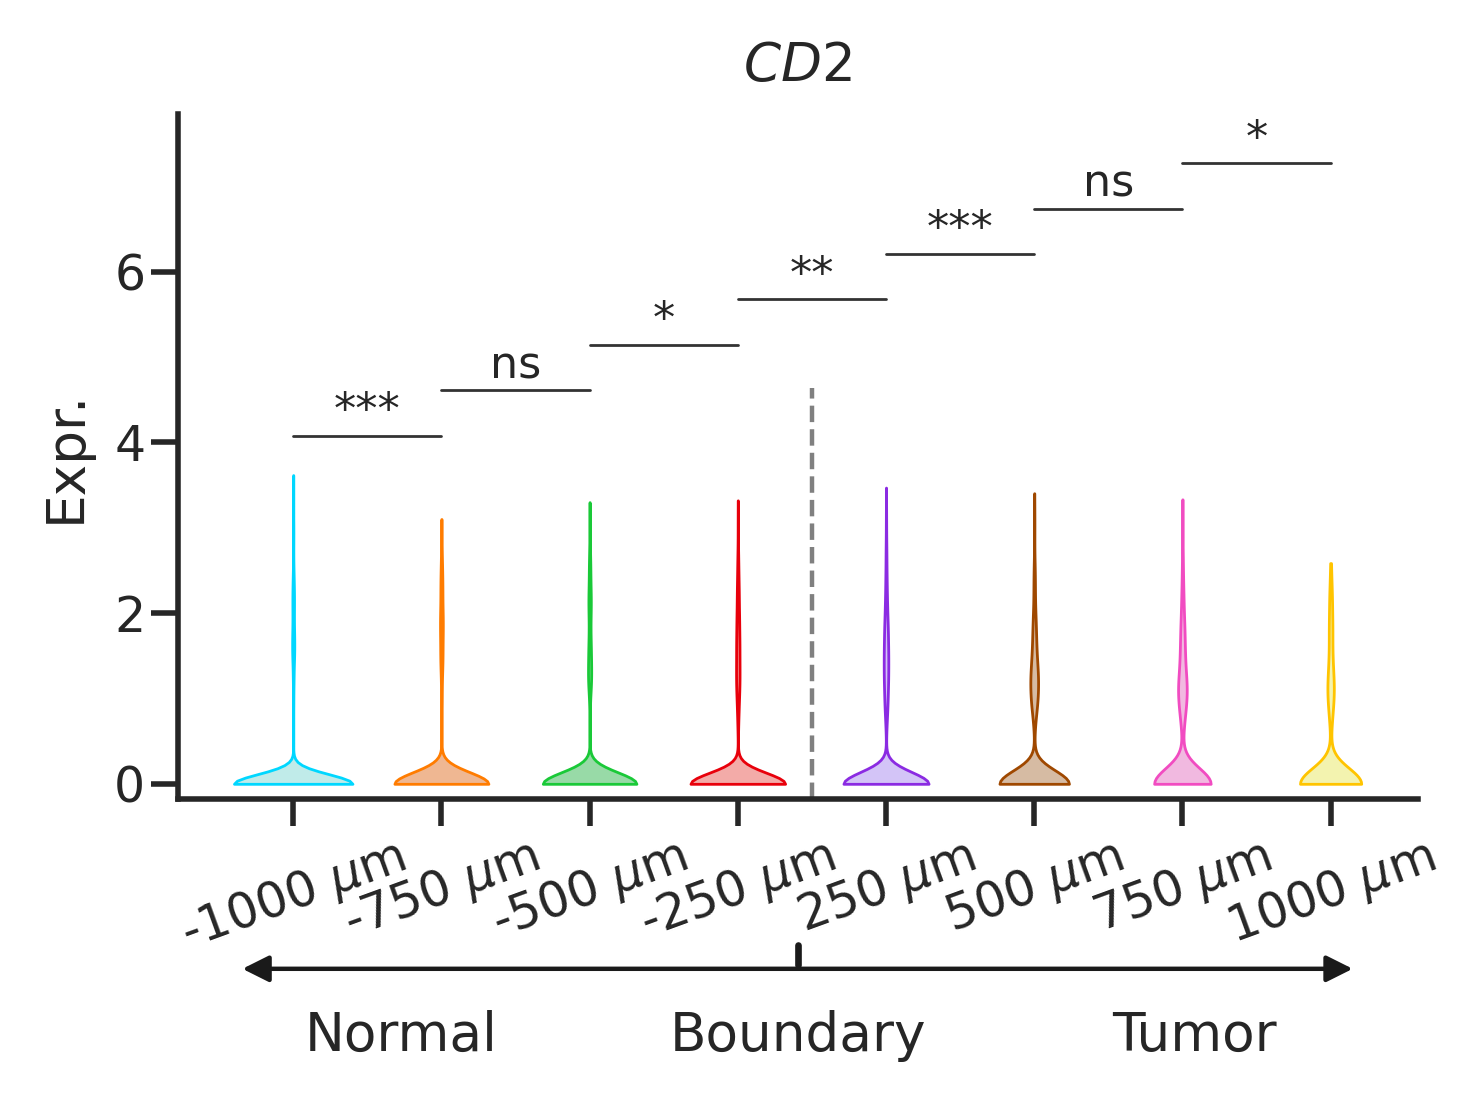

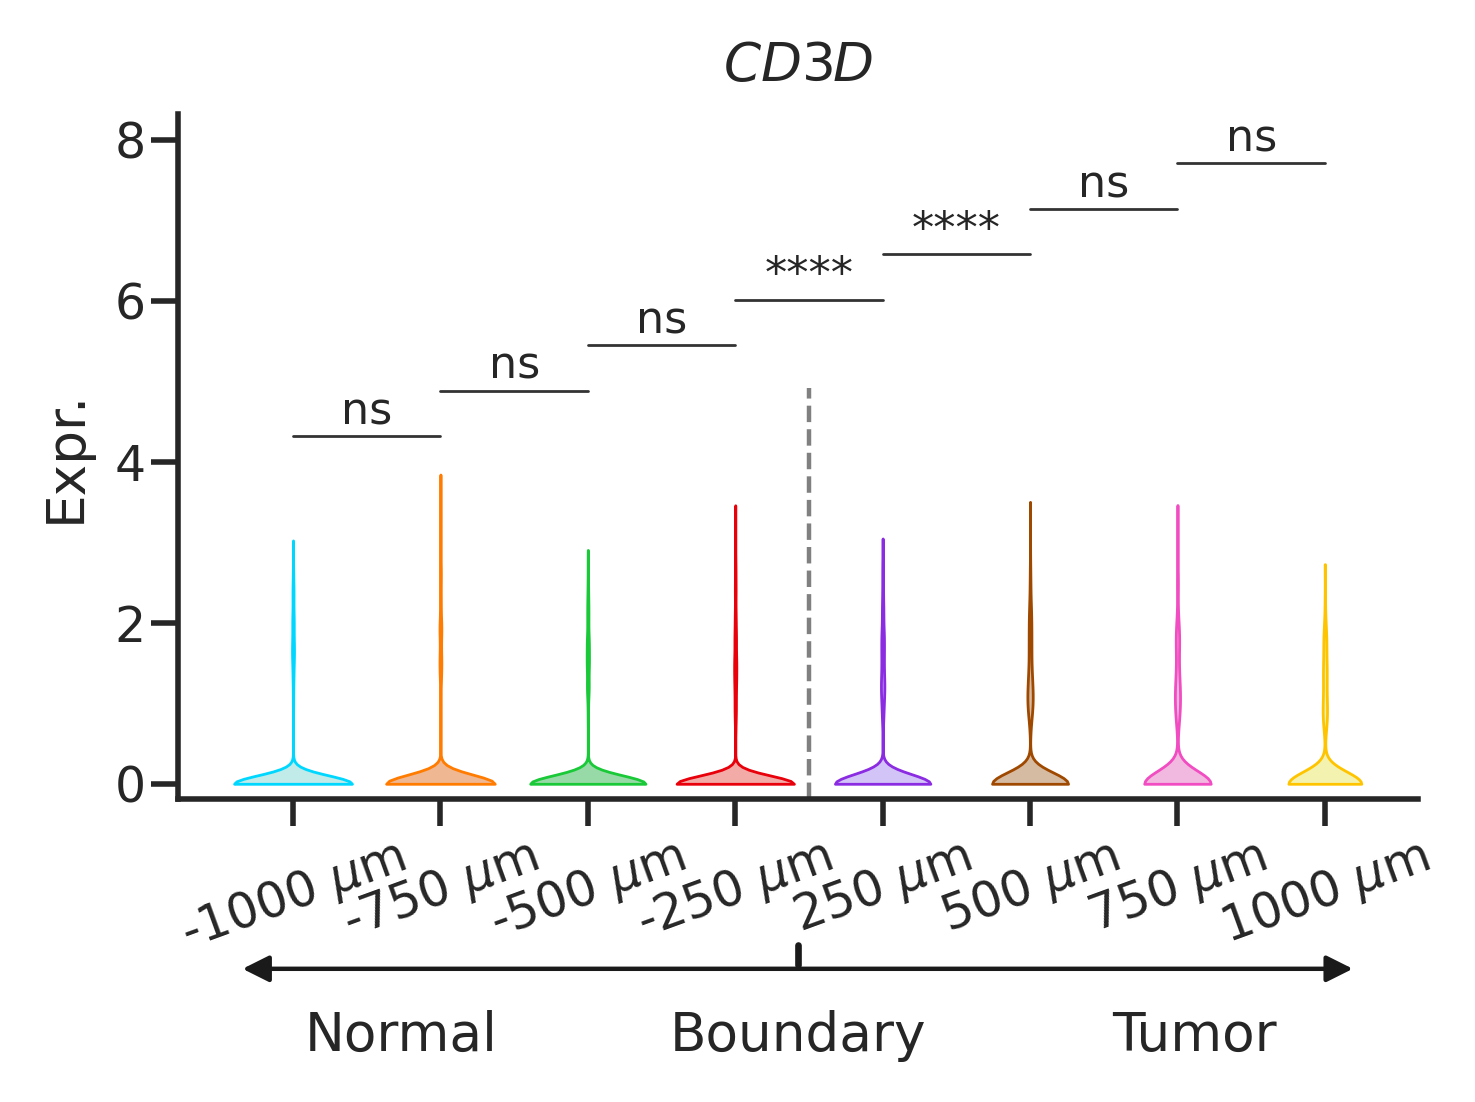

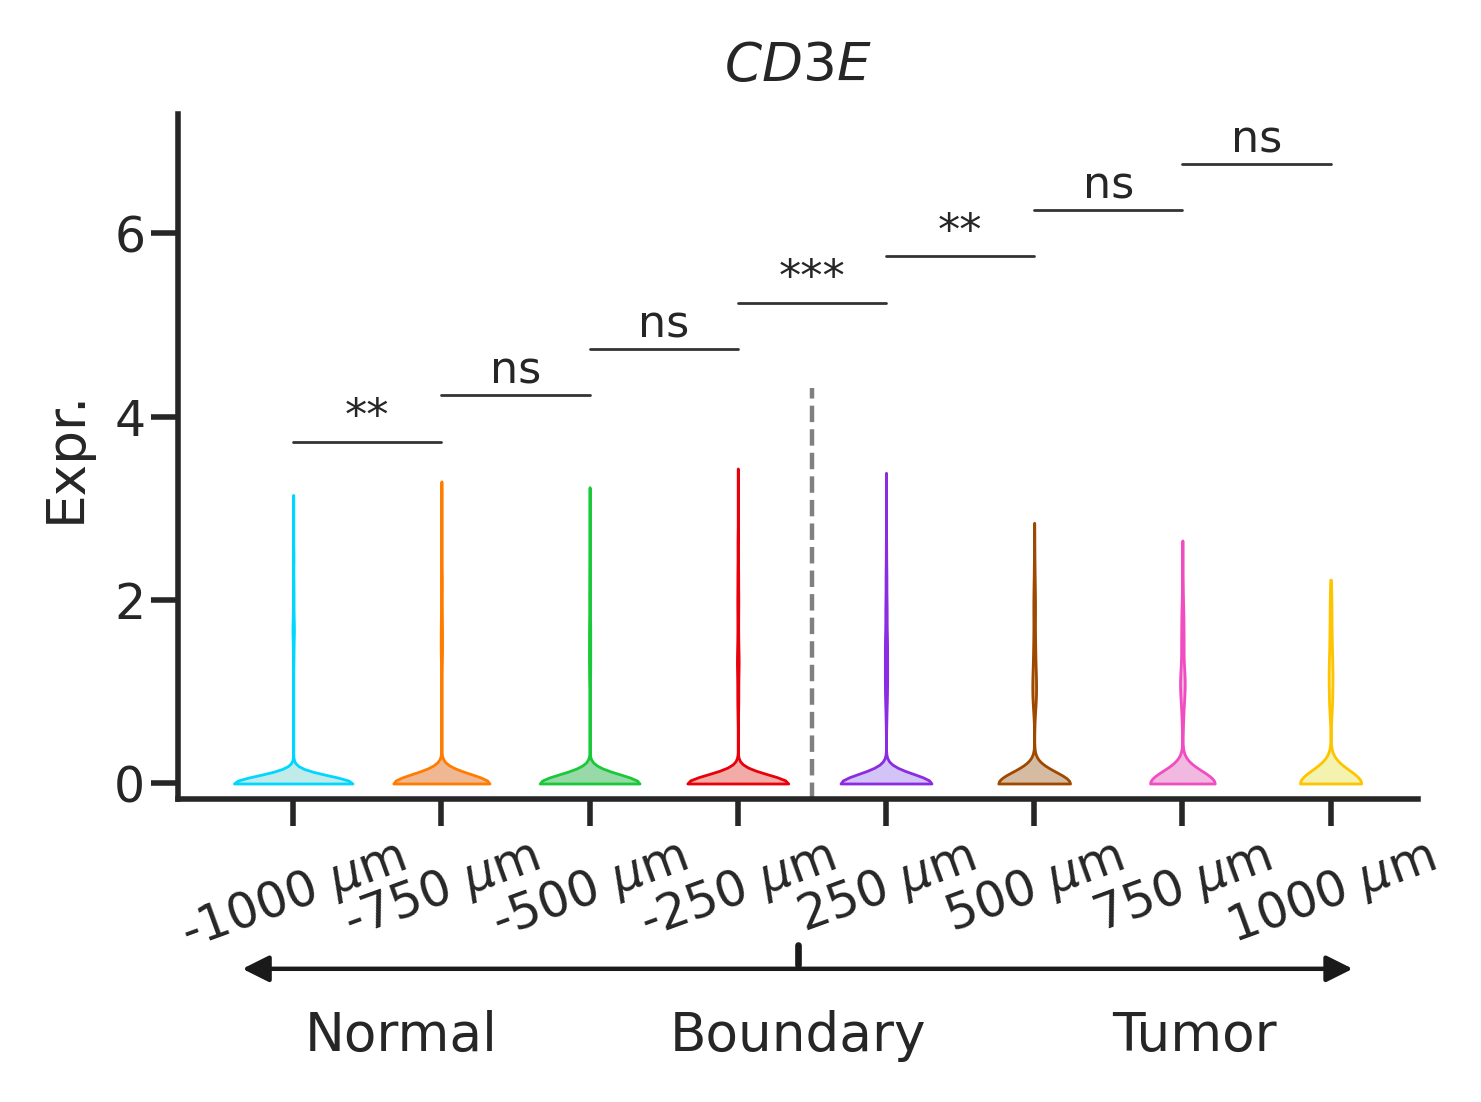

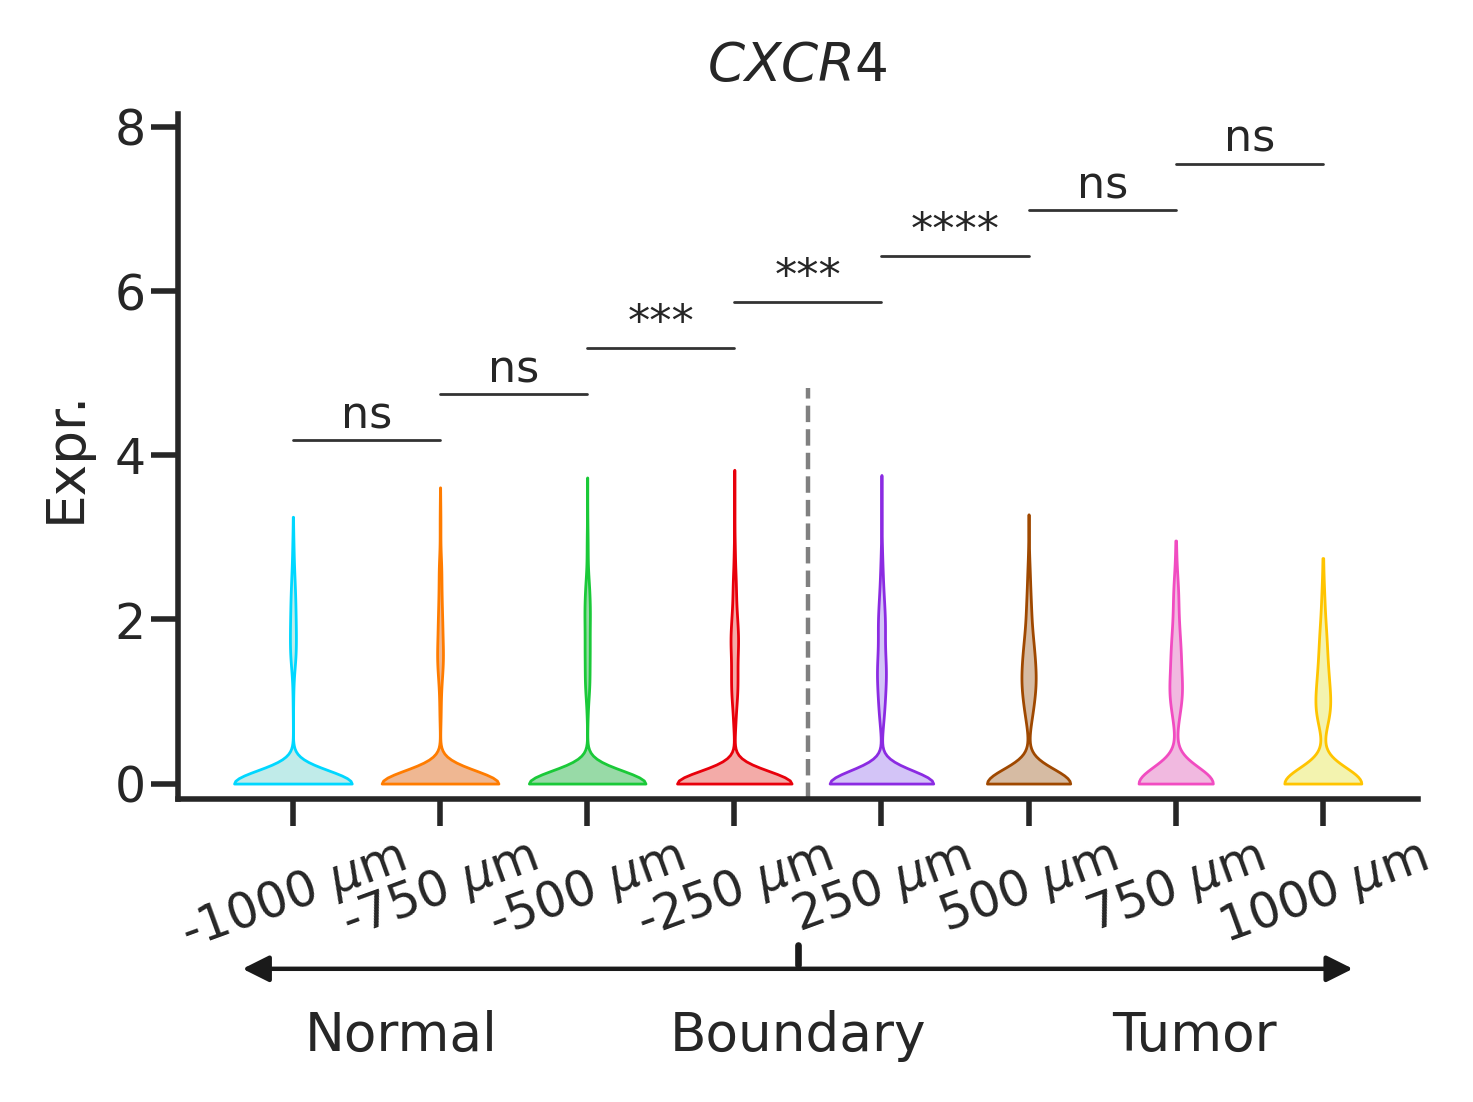

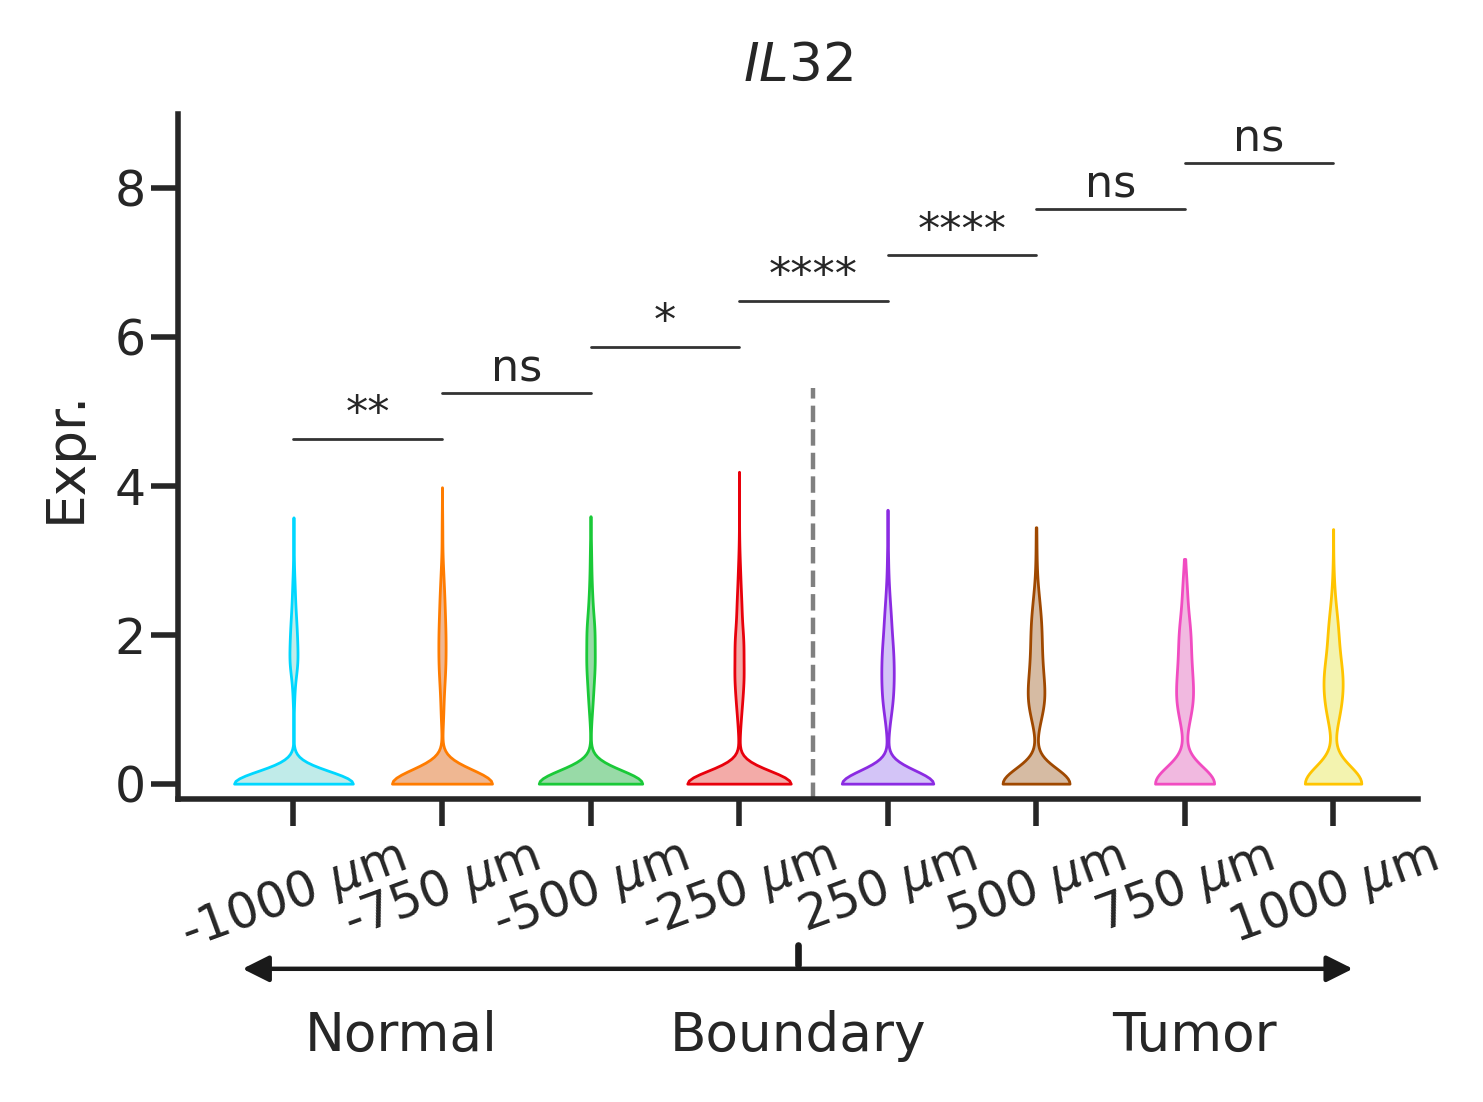

In [53]:
for gene in gene_dict[celltype]:
    plot_show(df_gene, gene, save=True,y_label='Expr.', gene=True, gene_cell_type=celltype)